In [1]:
import torch
import json
import numpy as np
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from gpt_model import GPTModel, DEFAULT_CFG
from sparse_auto_encoder import SparseAutoencoder

In [2]:
device = "cpu"

In [3]:
model = GPTModel(DEFAULT_CFG)
checkpoint = torch.load("model_896_14_8_256.pth", weights_only=True, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval();

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
sae_1 = SparseAutoencoder(input_dim=896, hidden_dim=2688).to(device)
sae_1.load_state_dict(torch.load("sae_models/sae_layer1.pth", map_location=torch.device('cpu')))
sae_1.eval();

sae_2 = SparseAutoencoder(input_dim=896, hidden_dim=2688).to(device)
sae_2.load_state_dict(torch.load("sae_models/sae_layer2.pth", map_location=torch.device('cpu')))
sae_2.eval();

sae_3 = SparseAutoencoder(input_dim=896, hidden_dim=3584).to(device)
sae_3.load_state_dict(torch.load("sae_models/sae_layer3.pth", map_location=torch.device('cpu')))
sae_3.eval();

sae_4 = SparseAutoencoder(input_dim=896, hidden_dim=3584).to(device)
sae_4.load_state_dict(torch.load("sae_models/sae_layer4.pth", map_location=torch.device('cpu')))
sae_4.eval();

sae_5 = SparseAutoencoder(input_dim=896, hidden_dim=3584).to(device)
sae_5.load_state_dict(torch.load("sae_models/sae_layer5.pth", map_location=torch.device('cpu')))
sae_5.eval();

sae_6 = SparseAutoencoder(input_dim=896, hidden_dim=4480).to(device)
sae_6.load_state_dict(torch.load("sae_models/sae_layer6.pth", map_location=torch.device('cpu')))
sae_6.eval();

sae_7 = SparseAutoencoder(input_dim=896, hidden_dim=4480).to(device)
sae_7.load_state_dict(torch.load("sae_models/sae_layer7.pth", map_location=torch.device('cpu')))
sae_7.eval();

sae_8 = SparseAutoencoder(input_dim=896, hidden_dim=4480).to(device)
sae_8.load_state_dict(torch.load("sae_models/sae_layer8.pth", map_location=torch.device('cpu')))
sae_8.eval();

In [6]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [7]:
def get_token_embeddings(text, model, tokenizer, layers=[6, 12]):
    """
    Extracts token embeddings from specified transformer layers.

    Args:
    - text (str): Input text.
    - model: Custom GPT model.
    - tokenizer: tiktoken encoding object.
    - layers (list): Transformer layers to extract embeddings from.

    Returns:
    - dict: Layer-wise token embeddings {layer_number: embeddings}
    """

    input_ids = text_to_token_ids(text, tokenizer).to(device)

    with torch.no_grad():
        _, hidden_states = model(input_ids, output_hidden_states=True)

    embeddings = {} 
    for layer in layers:
        if layer - 1 < len(hidden_states):
            embeddings[layer] = hidden_states[layer - 1].squeeze(0).cpu().numpy()
        else:
            print(f"⚠️ Warning: Layer {layer} is out of range (max index {len(hidden_states) - 1})")

    return embeddings

In [8]:
with open("theme_bias_analysis.json", "r", encoding="utf-8") as f:
    concept_to_texts = json.load(f)

sentences = []
for concept in concept_to_texts:
    sentences += concept_to_texts[concept]

print(f"Total of {len(sentences)} sentences accross {len(concept_to_texts)} concepts.")

inputs = [text_to_token_ids(text, tokenizer) for text in sentences]

Total of 318 sentences accross 11 concepts.


In [9]:
def exract_latent_activations(sae, layer):
    all_latents = []
    for sentence in sentences:
        idx = text_to_token_ids(sentence, tokenizer)
    
        # Get hidden state from the layer
        with torch.no_grad():
            _, hidden_states, attn_weights = model(idx, output_hidden_states=True, output_attentions_weights=True)
            h_layer = hidden_states[layer - 1][0]
            
            attn = attn_weights[layer - 1][0]  # [n_heads, seq_len, seq_len]
            attn_to_all = attn[:, -1, :]           # attention from final token to all tokens
            avg_attn_weights = attn_to_all.mean(dim=0)  # shape: [seq_len]

            weighted_hidden = torch.sum(h_layer * avg_attn_weights.unsqueeze(1), dim=0)  # shape: [emb_dim]
    
            # SAE encode + top-k
            x = weighted_hidden.unsqueeze(0) - sae.decoder.bias - sae.pre_encoder_bias
            z = sae.encoder(x)
            z = sae.topk(z)
    
            all_latents.append(z.squeeze(0))
    
    latent_activations = torch.stack(all_latents)
    torch.save(latent_activations, f"latent_activations_l{layer}.pt")
    print(f"✅ Saved latent_activations_l{layer}.pt with shape:", latent_activations.shape)

    return latent_activations

In [ ]:
def get_selective_neurons(latent_activations, layer=6):
    # Count how many examples each neuron fires on with value > 5
    activation_counts = (latent_activations > 5).sum(dim=0)  # shape: [3072]
    
    # Define selectivity range: not too rare, not too general
    min_active, max_active = 5, 150
    selective_neurons = [
        idx for idx, count in enumerate(activation_counts.tolist())
        if min_active <= count <= max_active
    ]
    
    # Save for further analysis
    torch.save(selective_neurons, f"selective_neuron_ids_l{layer}.pt")
    
    # Optional: Show distribution
    df = pd.DataFrame({
        "Neuron ID": list(range(latent_activations.shape[1])),
        "Activation Count": activation_counts.tolist(),
        "Is Selective": [i in selective_neurons for i in range(latent_activations.shape[1])]
    })
    
    print(df[df["Is Selective"]].sort_values("Activation Count", ascending=False))

    return selective_neurons

In [11]:
# Load saved tensors
# latent_activations = torch.load("latent_activations.pt")  # shape: [210, 3072]
# selective_neurons = torch.load("selective_neuron_ids.pt")  # list of neuron indices

def get_topk_activ_sentences(latent_activations, selective_neurons, layer=6, top_k=10, print_results=False):
    # Dictionary to store results
    neuron_top_sentences = {}
    
    for neuron in selective_neurons:
        activations = latent_activations[:, neuron]
        top_vals, top_indices = torch.topk(activations, k=top_k)
        top_sents = [sentences[i] for i in top_indices]
        neuron_top_sentences[neuron] = top_sents
    
    
    with open(f"selective_neuron_top_sentences_l{layer}.json", "w") as f:
        json.dump(neuron_top_sentences, f, indent=2)
    
    # Print out results for inspection
    if print_results:
        for neuron, sents in neuron_top_sentences.items():
            print(f"\nNeuron {neuron} (Top {top_k} activations):")
            for s in sents:
                print("  ", s)

    return neuron_top_sentences

In [22]:
# with open("selective_neuron_top_sentences.json", "r") as f:
#     neuron_sentences = json.load(f)

def get_neuron_theme_analysis(concept_to_texts, neuron_sentences, layer=6, base_dir="sae_probing"):
    # === Invert theme-to-sentence to sentence-to-theme ===
    sentence_to_theme = {}
    for theme, top_sentences in concept_to_texts.items():
        for sent in top_sentences:
            sentence_to_theme[sent] = theme
    
    # === Analyze Each Neuron ===
    neuron_theme_analysis = {}
    
    for neuron, top_sents in neuron_sentences.items():
        theme_counts = defaultdict(int)
    
        for sent in top_sents:
            if sent in sentence_to_theme:
                theme = sentence_to_theme[sent]
                theme_counts[theme] += 1
    
        # Sort by frequency
        sorted_themes = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True)
    
        primary = {"category": "UNK", "count": 0}
        secondary = {"category": "UNK", "count": 0}
    
        if sorted_themes:
            if sorted_themes[0][1] >= 4 and primary["category"] == "UNK":
                primary = {"category": sorted_themes[0][0], "count": sorted_themes[0][1]}
            elif sorted_themes[0][1] > 2:
                secondary = {"category": sorted_themes[0][0], "count": sorted_themes[0][1]}
    
            if len(sorted_themes) > 1 and secondary["category"] == "UNK":
                if sorted_themes[1][1] > 1:
                    secondary = {"category": sorted_themes[1][0], "count": sorted_themes[1][1]}
    
        neuron_theme_analysis[neuron] = {
            "primary_category": primary["category"],
            "primary_count": primary["count"],
            "secondary_category": secondary["category"],
            "secondary_count": secondary["count"]
        }
    
    # === Save to JSON ===
    with open(os.path.join(base_dir, f"neuron_theme_mapping_l{layer}.json"), "w") as f:
        json.dump(neuron_theme_analysis, f, indent=2)
    
    print("✅ Saved neuron mappings to neuron_theme_mapping.json")
    return neuron_theme_analysis

In [23]:
# Load the JSON file
# with open("neuron_theme_mapping.json", "r") as f:
#     neuron_theme_mapping = json.load(f)


def get_dual_themed_neurons(neuron_theme_mapping):
    found = False
        
    # Loop through each neuron and check for both categories
    for neuron, info in neuron_theme_mapping.items():
        primary = info["primary_category"].strip().lower()
        secondary = info["secondary_category"].strip().lower()
    
        if primary != "unk" and secondary != "unk":
            found = True
            print(f"Neuron {neuron}: primary = {primary}, secondary = {secondary}")
    
    if not found:
        print("No dual concept neurons found!")

In [24]:
def plot_concept_similarity_matrix(neuron_theme_mapping, title="Concept Similarity Matrix"):
    # Count co-occurrences
    co_occurrence = defaultdict(lambda: defaultdict(int))
    concepts = set()

    for neuron, info in neuron_theme_mapping.items():
        primary = info["primary_category"].strip().lower()
        secondary = info["secondary_category"].strip().lower()

        if primary != "unk" and secondary != "unk":
            co_occurrence[primary][secondary] += 1
            concepts.add(primary)
            concepts.add(secondary)

    concepts = sorted(concepts)
    
    # Create a DataFrame matrix
    matrix = pd.DataFrame(0, index=concepts, columns=concepts)
    for primary in concepts:
        for secondary in concepts:
            matrix.loc[primary, secondary] = co_occurrence[primary][secondary]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Secondary Concept")
    plt.ylabel("Primary Concept")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [46]:
def get_strongest_associations(layer_idx, base_dir="sae_probing"):
    """
    Load a neuron-theme mapping JSON file for the given layer, 
    extract neurons with primary concepts, and return a DataFrame 
    sorted by primary_count in descending order.
    
    Parameters:
        layer_idx (int): The transformer layer index.
        path_template (str): Template string for the file path. 
                             Must include one {} placeholder for layer index.
                             
    Returns:
        pd.DataFrame: A DataFrame with columns:
            ['neuron idx', 'associated concept', 'activations count', 'secondary concept']
    """
    
    with open(os.path.join(base_dir, f"neuron_theme_mapping_l{layer_idx}.json"), "r") as f:
        data = json.load(f)

    records = []

    for neuron, info in data.items():
        primary = info.get("primary_category", "").strip().lower()
        primary_count = info.get("primary_count", 0)
        secondary = info.get("secondary_category", "").strip().lower()

        if primary and primary != "unk":
            records.append({
                "neuron idx": int(neuron),
                "associated concept": primary,
                "activations count": primary_count,
                "secondary concept": secondary if secondary and secondary != "unk" else None
            })
            
    if records:
        df = pd.DataFrame(records)
        df.sort_values(by="activations count", ascending=False, inplace=True)
        df.reset_index(drop=True, inplace=True)
    else:
        print("⚠️ No records found — DataFrame will be empty.")
        df = pd.DataFrame(columns=["neuron idx", "associated concept", "activations count", "secondary concept"])
    
    return df

In [62]:
import matplotlib.pyplot as plt
import networkx as nx

color_map = {
    "female": "#FAD7AC",
    "male": "#cc9290",
    "marriage": "#ed76b3",
    "love": "#f4847a",
    "wealth": "#DAE8FC",
    "emotion": "#9467bd",
    "family": "#D0CEE1",
    "duty": "#a4d9f2",
    "scandal and reputation": "#BAC8D3",
    "society": "#D5E7D4",
    "neutral": "#e5ced0",
    "class": "#FFF1CC"
}

def plot_dual_theme_graph(data, *, color_map=color_map, ax=None, return_fig=False, seed=62):
    """Builds the dual-theme concept graph. Does NOT call plt.show().

    Returns:
        (fig, ax) if return_fig=True, else None.
    """
    # 1) Extract edges
    edges = []
    for neuron_id, info in (data or {}).items():
        primary = str(info.get("primary_category", "")).strip(" ,").lower()
        secondary = str(info.get("secondary_category", "")).strip(" ,").lower()
        if primary and secondary and primary != "unk" and secondary != "unk":
            edges.append((primary, secondary))

    # 2) If nothing to draw, return a placeholder fig/ax (optional)
    if not edges:
        fig, axp = plt.subplots(figsize=(6, 3))
        axp.text(0.5, 0.5, "No dual-theme data", ha="center", va="center")
        axp.axis("off")
        fig.tight_layout()
        return (fig, axp) if return_fig else None

    # 3) Build graph
    G = nx.MultiGraph()
    G.add_edges_from(edges)

    # 4) Create axes if needed
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15))
        created_fig = True
    else:
        fig = ax.figure

    # 5) Layout & draw
    # scale k by number of nodes a bit so the layout doesn’t collapse on many nodes
    k = 0.75 / max(len(G.nodes), 1) ** 0.25
    pos = nx.spring_layout(G, k=k, seed=seed)

    unique_nodes = list(G.nodes())
    node_colors = [color_map.get(node, "#cccccc") for node in unique_nodes]

    nx.draw_networkx_nodes(G, pos, node_size=8000, node_color=node_colors, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", ax=ax)

    # draw weighted edges (collapsed multi-edges)
    drawn = set()
    for u, v in G.edges():
        key = tuple(sorted((u, v)))
        if key in drawn:
            continue
        width = 1 + G.number_of_edges(u, v)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=0.5, ax=ax)
        drawn.add(key)

    ax.set_title("Dual-Theme SAE Neuron Concept Graph", fontsize=16)
    ax.axis("off")
    fig.tight_layout()

    if return_fig:
        return fig, ax

In [63]:
import io, os, json
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

def _ensure_dir(d):
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def _save_json(obj, path):
    try:
        with open(path, "w") as f:
            json.dump(obj, f, indent=2)
    except Exception as e:
        print(f"⚠️ Failed to save {path}: {e}")

def _save_empty_plot(path, title="No data to plot"):
    plt.figure(figsize=(6, 3))
    plt.text(0.5, 0.5, title, ha="center", va="center")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

def probe_layer(sae, layer_idx, out_prefix="layer_output", base_dir="sae_probing"):
    _ensure_dir(base_dir)

    text_log_path = os.path.join(base_dir, f"{out_prefix}_l{layer_idx}.txt")
    sim_png_path  = os.path.join(base_dir, f"{out_prefix}_l{layer_idx}_similarity.png")
    dual_png_path = os.path.join(base_dir, f"{out_prefix}_l{layer_idx}_dual_theme.png")

    # files for intermediates (debugging)
    sel_json_path   = os.path.join(base_dir, f"selective_neurons_l{layer_idx}.json")
    topk_json_path  = os.path.join(base_dir, f"topk_sentences_l{layer_idx}.json")
    map_json_path   = os.path.join(base_dir, f"neuron_theme_mapping_l{layer_idx}.json")
    strong_json_path= os.path.join(base_dir, f"strongest_associations_l{layer_idx}.json")

    buf = io.StringIO()
    with redirect_stdout(buf):
        print(50*'-')
        print(f'Layer {layer_idx} — Selective neurons:')
        latent_activations = exract_latent_activations(sae, layer=layer_idx)
        print(f"latent_activations shape: {getattr(latent_activations, 'shape', None)}")
        selective_neurons = get_selective_neurons(latent_activations, layer=layer_idx)
        print(f"#selective_neurons: {len(selective_neurons) if selective_neurons is not None else 0}")
        _save_json(selective_neurons, sel_json_path)
        print(50*'-')

        neuron_top_sentences = get_topk_activ_sentences(
            latent_activations, selective_neurons, top_k=10, layer=layer_idx
        )
        n_top = 0
        if isinstance(neuron_top_sentences, dict):
            n_top = sum(len(v) for v in neuron_top_sentences.values())
        elif isinstance(neuron_top_sentences, list):
            n_top = len(neuron_top_sentences)
        print(f"Top-k activations collected: {n_top}")
        _save_json(neuron_top_sentences, topk_json_path)

        neuron_theme_mapping = get_neuron_theme_analysis(
            concept_to_texts, neuron_top_sentences, layer=layer_idx, base_dir=base_dir
        )
        n_map = 0
        if isinstance(neuron_theme_mapping, dict):
            # assume mapping like {neuron_id: {primary:..., secondary:..., counts...}}
            n_map = len(neuron_theme_mapping)
        print(f"Neuron-theme mappings: {n_map}")
        _save_json(neuron_theme_mapping, map_json_path)

        strongest_associations = get_strongest_associations(layer_idx, base_dir)
        strong_neurons_exist = strongest_associations.size > 0
        print(50*'-')
        print('Strongest Concepts:')
        print(strongest_associations)
        _save_json(strongest_associations, strong_json_path)

        print(50*'-')
        print('Concept similarity matrix:')
        if strong_neurons_exist and neuron_theme_mapping and isinstance(neuron_theme_mapping, dict):
            try:
                plot_concept_similarity_matrix(
                    neuron_theme_mapping,
                    title=f"SAE {layer_idx} - Concept Similarity Matrix"
                )
                plt.savefig(sim_png_path, dpi=150, bbox_inches="tight")
                plt.close()
                print(f"Saved similarity heatmap → {sim_png_path}")
            except Exception as e:
                print(f"⚠️ Heatmap failed: {e}")
                _save_empty_plot(sim_png_path, "Similarity matrix unavailable")
        else:
            print("⚠️ Empty neuron_theme_mapping → skipping heatmap.")
            _save_empty_plot(sim_png_path, "No similarity data")

        print(50*'-')
        print('Dual themed neurons:')
        if strong_neurons_exist and neuron_theme_mapping and isinstance(neuron_theme_mapping, dict):
            try:
                get_dual_themed_neurons(neuron_theme_mapping)
            except Exception as e:
                print(f"⚠️ get_dual_themed_neurons() error: {e}")

            # (Re)load mapping JSON to be consistent with your plotting call
            try:
                with open(map_json_path, "r") as f:
                    data = json.load(f)
            except Exception as e:
                print(f"⚠️ Failed to reload mapping JSON: {e}")
                data = None

            if data:
                try:
                    fig_ax = plot_dual_theme_graph(data, return_fig=True)
                    if fig_ax:
                        fig, _ = fig_ax
                        fig.savefig(dual_png_path, dpi=150, bbox_inches="tight")
                        plt.close(fig)
                        print(f"Saved dual-theme graph → {dual_png_path}")
                    else:
                        _save_empty_plot(dual_png_path, "Dual-theme graph unavailable")
                except Exception as e:
                    print(f"⚠️ Dual-theme plot failed: {e}")
                    _save_empty_plot(dual_png_path, "Dual-theme graph unavailable")
        else:
            print("⚠️ Empty neuron_theme_mapping → skipping dual-theme graph.")
            _save_empty_plot(dual_png_path, "No dual-theme data")

    # persist text log
    with open(text_log_path, "w") as f:
        f.write(buf.getvalue())

    print(f"✅ Saved outputs for layer {layer_idx}:")
    print(f"- Log: {text_log_path}")
    print(f"- Similarity plot: {sim_png_path}")
    print(f"- Dual-theme plot: {dual_png_path}")
    print(f"- Selective neurons JSON: {sel_json_path}")
    print(f"- Top-k sentences JSON: {topk_json_path}")
    print(f"- Mapping JSON: {map_json_path}")
    print(f"- Strongest associations JSON: {strong_json_path}")

    # return a small summary you can inspect programmatically
    return {
        "layer": layer_idx,
        "paths": {
            "log": text_log_path,
            "similarity_png": sim_png_path,
            "dual_theme_png": dual_png_path,
            "selective_neurons_json": sel_json_path,
            "topk_sentences_json": topk_json_path,
            "mapping_json": map_json_path,
            "strongest_json": strong_json_path,
        },
        "counts": {
            "n_selective": len(selective_neurons) if selective_neurons is not None else 0,
            "n_top_pairs": n_top,
            "n_mapped": n_map,
        }
    }

In [64]:
probe_layer(sae_1, 1)

✅ Saved outputs for layer 1:
- Log: sae_probing/layer_output_l1.txt
- Similarity plot: sae_probing/layer_output_l1_similarity.png
- Dual-theme plot: sae_probing/layer_output_l1_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l1.json
- Top-k sentences JSON: sae_probing/topk_sentences_l1.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l1.json
- Strongest associations JSON: sae_probing/strongest_associations_l1.json


{'layer': 1,
 'paths': {'log': 'sae_probing/layer_output_l1.txt',
  'similarity_png': 'sae_probing/layer_output_l1_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l1_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l1.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l1.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l1.json',
  'strongest_json': 'sae_probing/strongest_associations_l1.json'},
 'counts': {'n_selective': 1, 'n_top_pairs': 10, 'n_mapped': 1}}

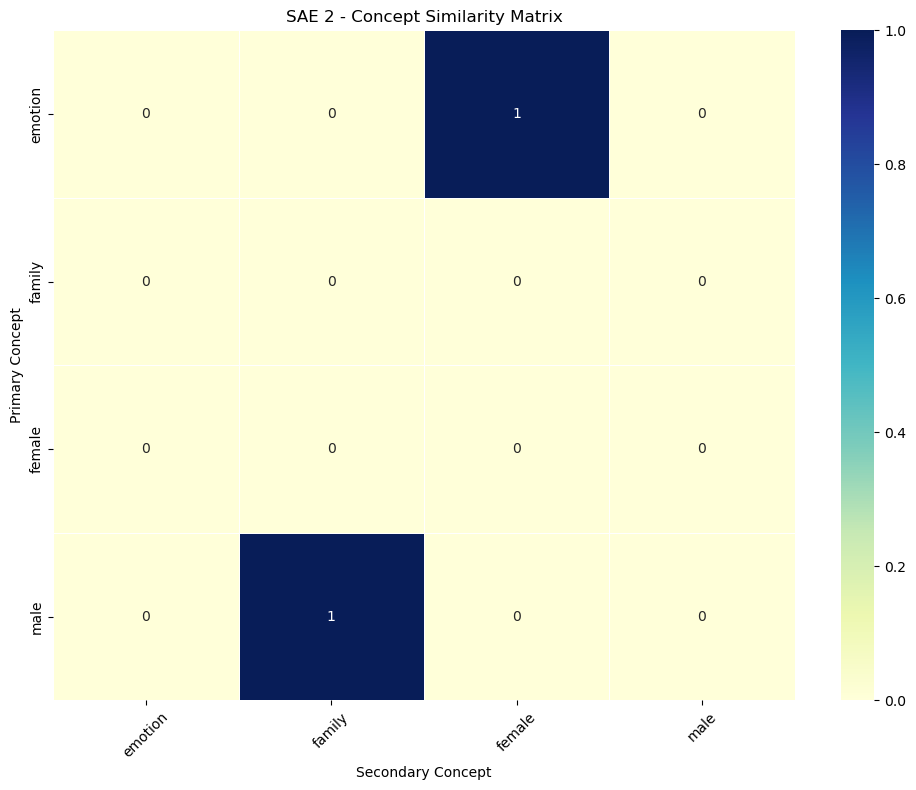

✅ Saved outputs for layer 2:
- Log: sae_probing/layer_output_l2.txt
- Similarity plot: sae_probing/layer_output_l2_similarity.png
- Dual-theme plot: sae_probing/layer_output_l2_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l2.json
- Top-k sentences JSON: sae_probing/topk_sentences_l2.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l2.json
- Strongest associations JSON: sae_probing/strongest_associations_l2.json


{'layer': 2,
 'paths': {'log': 'sae_probing/layer_output_l2.txt',
  'similarity_png': 'sae_probing/layer_output_l2_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l2_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l2.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l2.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l2.json',
  'strongest_json': 'sae_probing/strongest_associations_l2.json'},
 'counts': {'n_selective': 3, 'n_top_pairs': 30, 'n_mapped': 3}}

In [65]:
probe_layer(sae_2, 2)

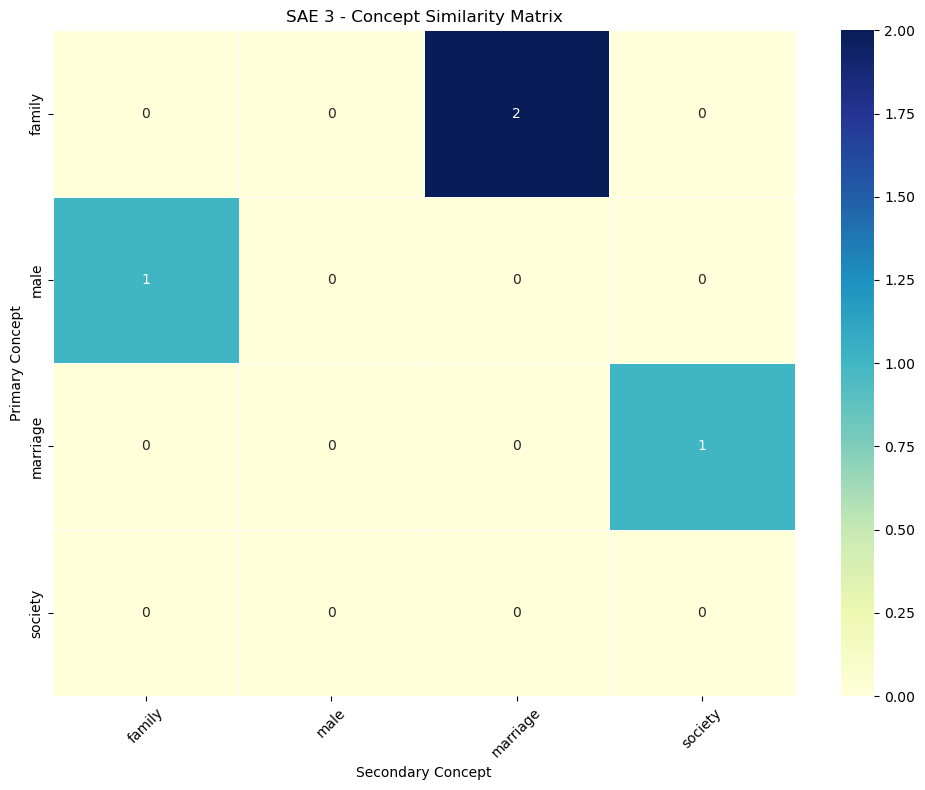

✅ Saved outputs for layer 3:
- Log: sae_probing/layer_output_l3.txt
- Similarity plot: sae_probing/layer_output_l3_similarity.png
- Dual-theme plot: sae_probing/layer_output_l3_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l3.json
- Top-k sentences JSON: sae_probing/topk_sentences_l3.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l3.json
- Strongest associations JSON: sae_probing/strongest_associations_l3.json


{'layer': 3,
 'paths': {'log': 'sae_probing/layer_output_l3.txt',
  'similarity_png': 'sae_probing/layer_output_l3_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l3_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l3.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l3.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l3.json',
  'strongest_json': 'sae_probing/strongest_associations_l3.json'},
 'counts': {'n_selective': 7, 'n_top_pairs': 70, 'n_mapped': 7}}

In [66]:
probe_layer(sae_3, 3)

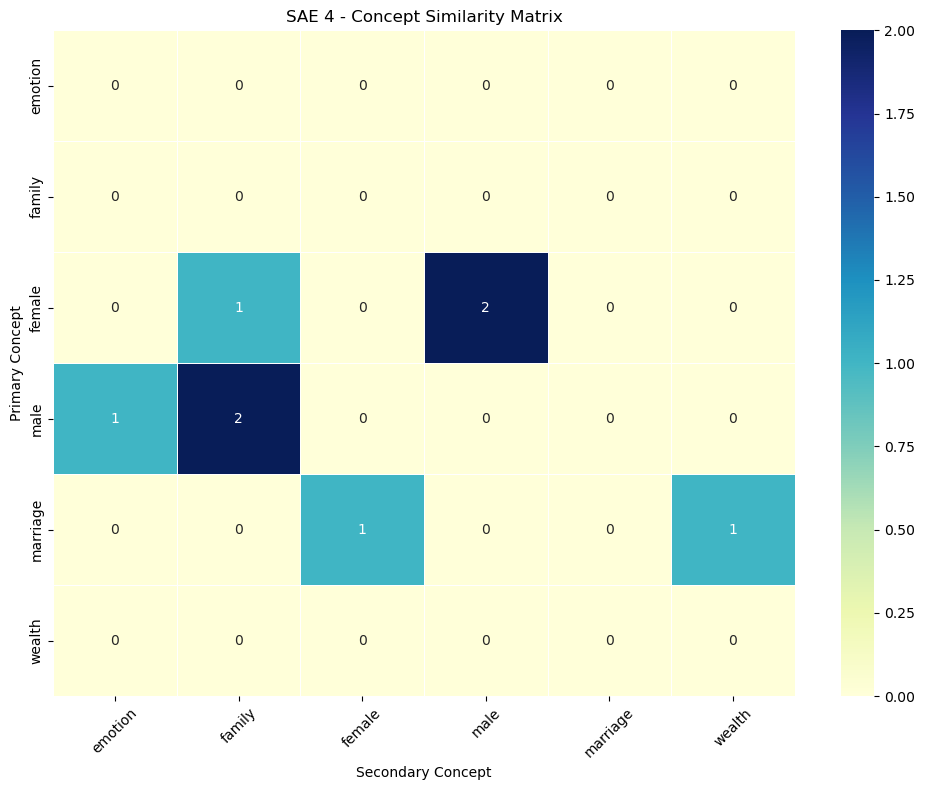

✅ Saved outputs for layer 4:
- Log: sae_probing/layer_output_l4.txt
- Similarity plot: sae_probing/layer_output_l4_similarity.png
- Dual-theme plot: sae_probing/layer_output_l4_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l4.json
- Top-k sentences JSON: sae_probing/topk_sentences_l4.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l4.json
- Strongest associations JSON: sae_probing/strongest_associations_l4.json


{'layer': 4,
 'paths': {'log': 'sae_probing/layer_output_l4.txt',
  'similarity_png': 'sae_probing/layer_output_l4_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l4_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l4.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l4.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l4.json',
  'strongest_json': 'sae_probing/strongest_associations_l4.json'},
 'counts': {'n_selective': 25, 'n_top_pairs': 250, 'n_mapped': 25}}

In [67]:
probe_layer(sae_4, 4)

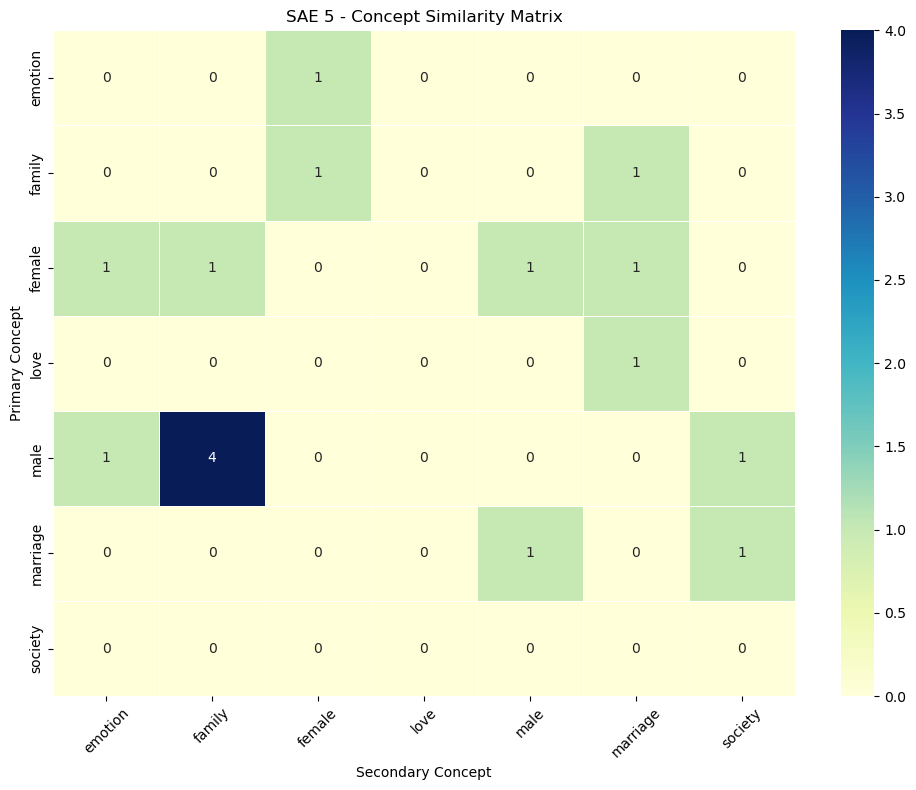

✅ Saved outputs for layer 5:
- Log: sae_probing/layer_output_l5.txt
- Similarity plot: sae_probing/layer_output_l5_similarity.png
- Dual-theme plot: sae_probing/layer_output_l5_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l5.json
- Top-k sentences JSON: sae_probing/topk_sentences_l5.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l5.json
- Strongest associations JSON: sae_probing/strongest_associations_l5.json


{'layer': 5,
 'paths': {'log': 'sae_probing/layer_output_l5.txt',
  'similarity_png': 'sae_probing/layer_output_l5_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l5_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l5.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l5.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l5.json',
  'strongest_json': 'sae_probing/strongest_associations_l5.json'},
 'counts': {'n_selective': 40, 'n_top_pairs': 400, 'n_mapped': 40}}

In [68]:
probe_layer(sae_5, 5)

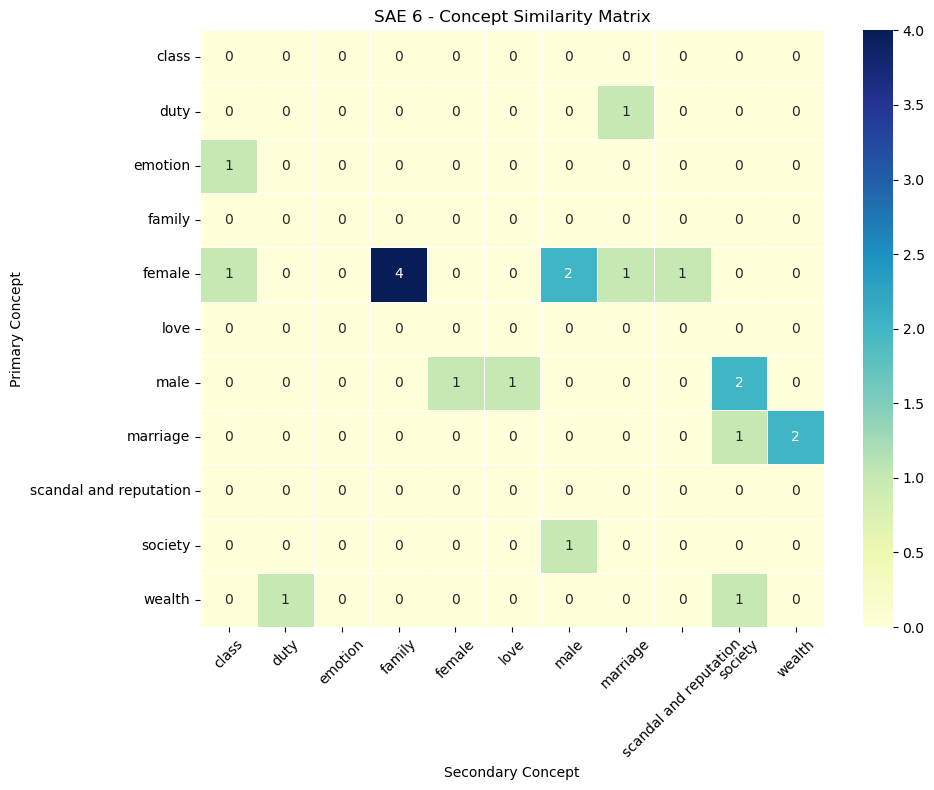

✅ Saved outputs for layer 6:
- Log: sae_probing/layer_output_l6.txt
- Similarity plot: sae_probing/layer_output_l6_similarity.png
- Dual-theme plot: sae_probing/layer_output_l6_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l6.json
- Top-k sentences JSON: sae_probing/topk_sentences_l6.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l6.json
- Strongest associations JSON: sae_probing/strongest_associations_l6.json


{'layer': 6,
 'paths': {'log': 'sae_probing/layer_output_l6.txt',
  'similarity_png': 'sae_probing/layer_output_l6_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l6_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l6.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l6.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l6.json',
  'strongest_json': 'sae_probing/strongest_associations_l6.json'},
 'counts': {'n_selective': 65, 'n_top_pairs': 650, 'n_mapped': 65}}

In [69]:
probe_layer(sae_6, 6)

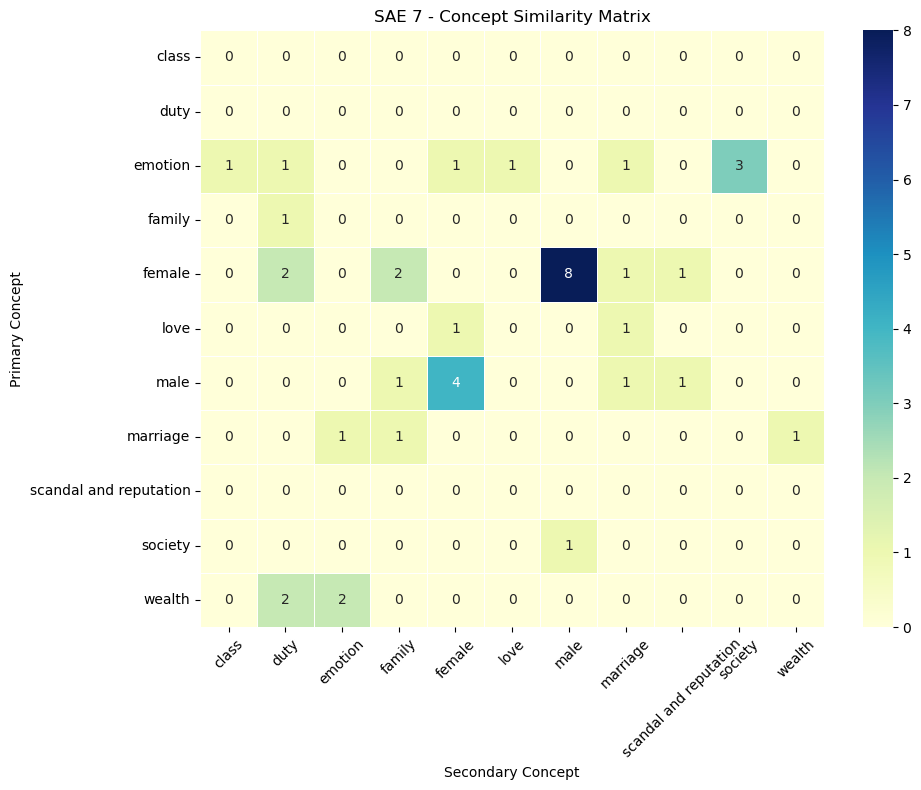

✅ Saved outputs for layer 7:
- Log: sae_probing/layer_output_l7.txt
- Similarity plot: sae_probing/layer_output_l7_similarity.png
- Dual-theme plot: sae_probing/layer_output_l7_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l7.json
- Top-k sentences JSON: sae_probing/topk_sentences_l7.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l7.json
- Strongest associations JSON: sae_probing/strongest_associations_l7.json


{'layer': 7,
 'paths': {'log': 'sae_probing/layer_output_l7.txt',
  'similarity_png': 'sae_probing/layer_output_l7_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l7_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l7.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l7.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l7.json',
  'strongest_json': 'sae_probing/strongest_associations_l7.json'},
 'counts': {'n_selective': 100, 'n_top_pairs': 1000, 'n_mapped': 100}}

In [70]:
probe_layer(sae_7, 7)

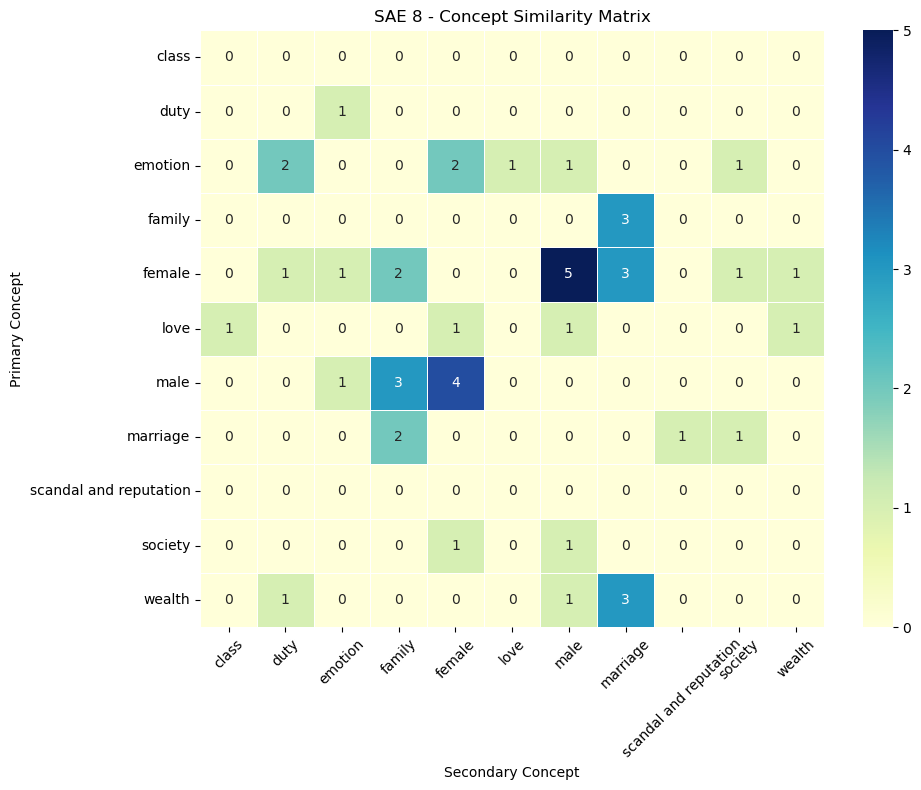

✅ Saved outputs for layer 8:
- Log: sae_probing/layer_output_l8.txt
- Similarity plot: sae_probing/layer_output_l8_similarity.png
- Dual-theme plot: sae_probing/layer_output_l8_dual_theme.png
- Selective neurons JSON: sae_probing/selective_neurons_l8.json
- Top-k sentences JSON: sae_probing/topk_sentences_l8.json
- Mapping JSON: sae_probing/neuron_theme_mapping_l8.json
- Strongest associations JSON: sae_probing/strongest_associations_l8.json


{'layer': 8,
 'paths': {'log': 'sae_probing/layer_output_l8.txt',
  'similarity_png': 'sae_probing/layer_output_l8_similarity.png',
  'dual_theme_png': 'sae_probing/layer_output_l8_dual_theme.png',
  'selective_neurons_json': 'sae_probing/selective_neurons_l8.json',
  'topk_sentences_json': 'sae_probing/topk_sentences_l8.json',
  'mapping_json': 'sae_probing/neuron_theme_mapping_l8.json',
  'strongest_json': 'sae_probing/strongest_associations_l8.json'},
 'counts': {'n_selective': 117, 'n_top_pairs': 1170, 'n_mapped': 117}}

In [71]:
probe_layer(sae_8, 8)

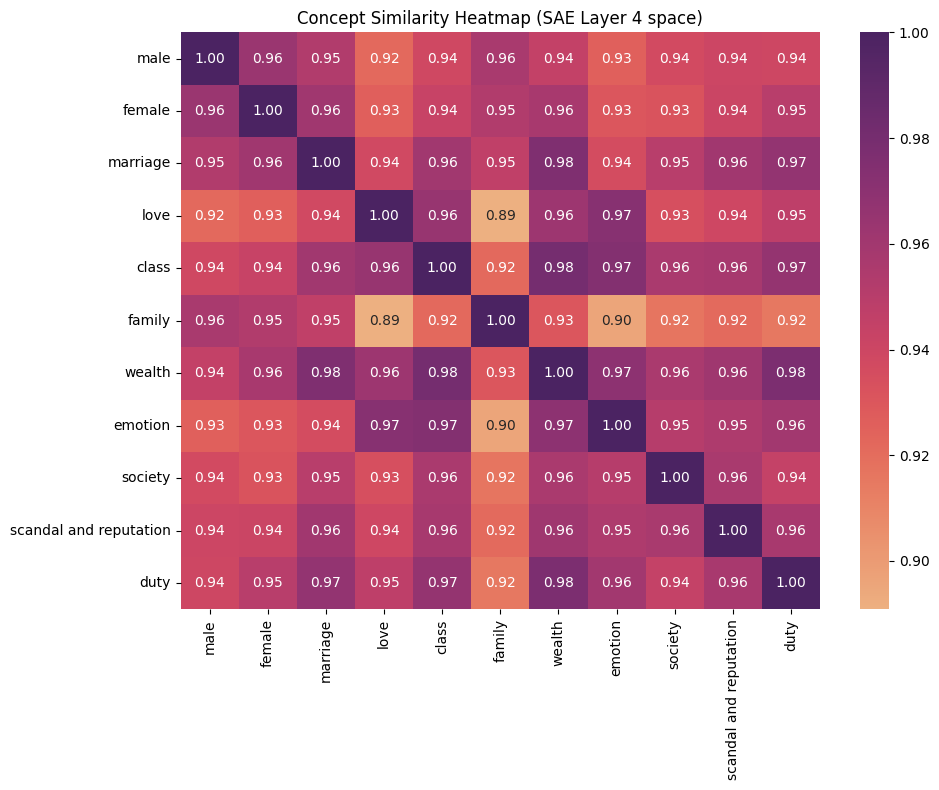

(tensor([[1.0000, 0.9635, 0.9530, 0.9216, 0.9386, 0.9567, 0.9449, 0.9257, 0.9370,
          0.9405, 0.9398],
         [0.9635, 1.0000, 0.9611, 0.9262, 0.9430, 0.9532, 0.9572, 0.9306, 0.9321,
          0.9414, 0.9500],
         [0.9530, 0.9611, 1.0000, 0.9379, 0.9603, 0.9467, 0.9761, 0.9364, 0.9501,
          0.9604, 0.9671],
         [0.9216, 0.9262, 0.9379, 1.0000, 0.9649, 0.8908, 0.9621, 0.9726, 0.9340,
          0.9392, 0.9472],
         [0.9386, 0.9430, 0.9603, 0.9649, 1.0000, 0.9216, 0.9802, 0.9741, 0.9563,
          0.9575, 0.9661],
         [0.9567, 0.9532, 0.9467, 0.8908, 0.9216, 1.0000, 0.9303, 0.8958, 0.9168,
          0.9215, 0.9154],
         [0.9449, 0.9572, 0.9761, 0.9621, 0.9802, 0.9303, 1.0000, 0.9696, 0.9562,
          0.9616, 0.9772],
         [0.9257, 0.9306, 0.9364, 0.9726, 0.9741, 0.8958, 0.9696, 1.0000, 0.9509,
          0.9545, 0.9598],
         [0.9370, 0.9321, 0.9501, 0.9340, 0.9563, 0.9168, 0.9562, 0.9509, 1.0000,
          0.9569, 0.9442],
         [0.9405, 0

In [29]:
compute_concept_similarity_heatmap(model, sae_4, tokenizer, layer_idx=4)

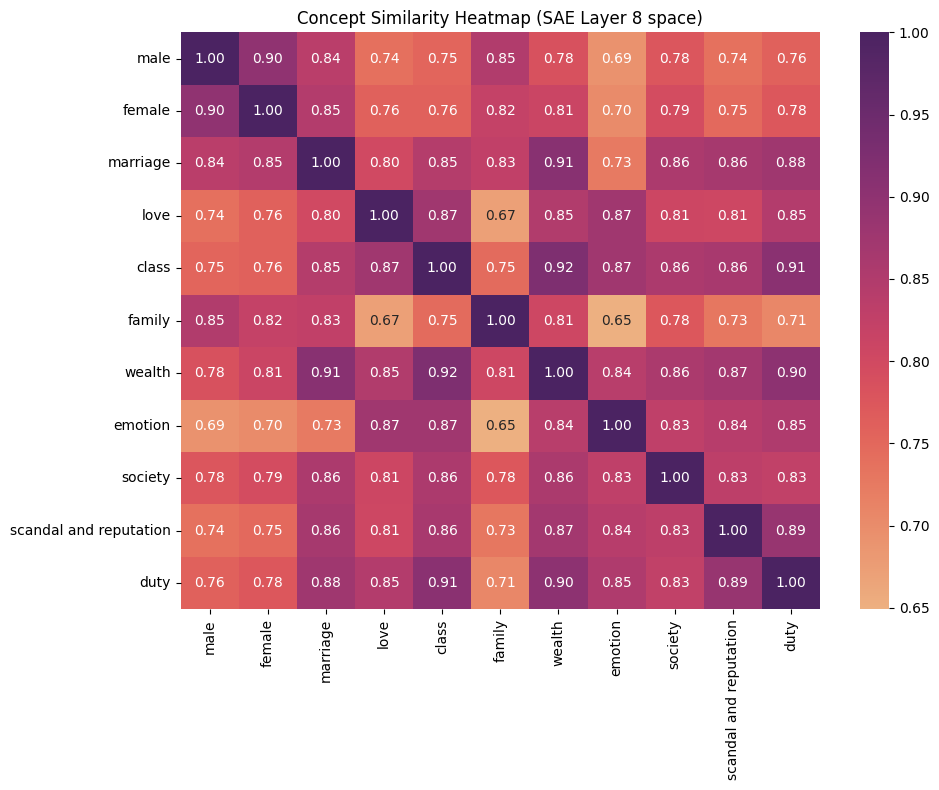

(tensor([[1.0000, 0.8973, 0.8365, 0.7390, 0.7535, 0.8496, 0.7848, 0.6916, 0.7772,
          0.7369, 0.7591],
         [0.8973, 1.0000, 0.8452, 0.7588, 0.7589, 0.8207, 0.8115, 0.7021, 0.7948,
          0.7478, 0.7751],
         [0.8365, 0.8452, 1.0000, 0.8007, 0.8450, 0.8270, 0.9092, 0.7257, 0.8569,
          0.8645, 0.8755],
         [0.7390, 0.7588, 0.8007, 1.0000, 0.8744, 0.6718, 0.8487, 0.8742, 0.8072,
          0.8058, 0.8461],
         [0.7535, 0.7589, 0.8450, 0.8744, 1.0000, 0.7453, 0.9233, 0.8748, 0.8569,
          0.8627, 0.9065],
         [0.8496, 0.8207, 0.8270, 0.6718, 0.7453, 1.0000, 0.8053, 0.6490, 0.7751,
          0.7288, 0.7069],
         [0.7848, 0.8115, 0.9092, 0.8487, 0.9233, 0.8053, 1.0000, 0.8391, 0.8585,
          0.8686, 0.9021],
         [0.6916, 0.7021, 0.7257, 0.8742, 0.8748, 0.6490, 0.8391, 1.0000, 0.8289,
          0.8401, 0.8527],
         [0.7772, 0.7948, 0.8569, 0.8072, 0.8569, 0.7751, 0.8585, 0.8289, 1.0000,
          0.8318, 0.8253],
         [0.7369, 0

In [30]:
compute_concept_similarity_heatmap(model, sae_8, tokenizer, layer_idx=8)

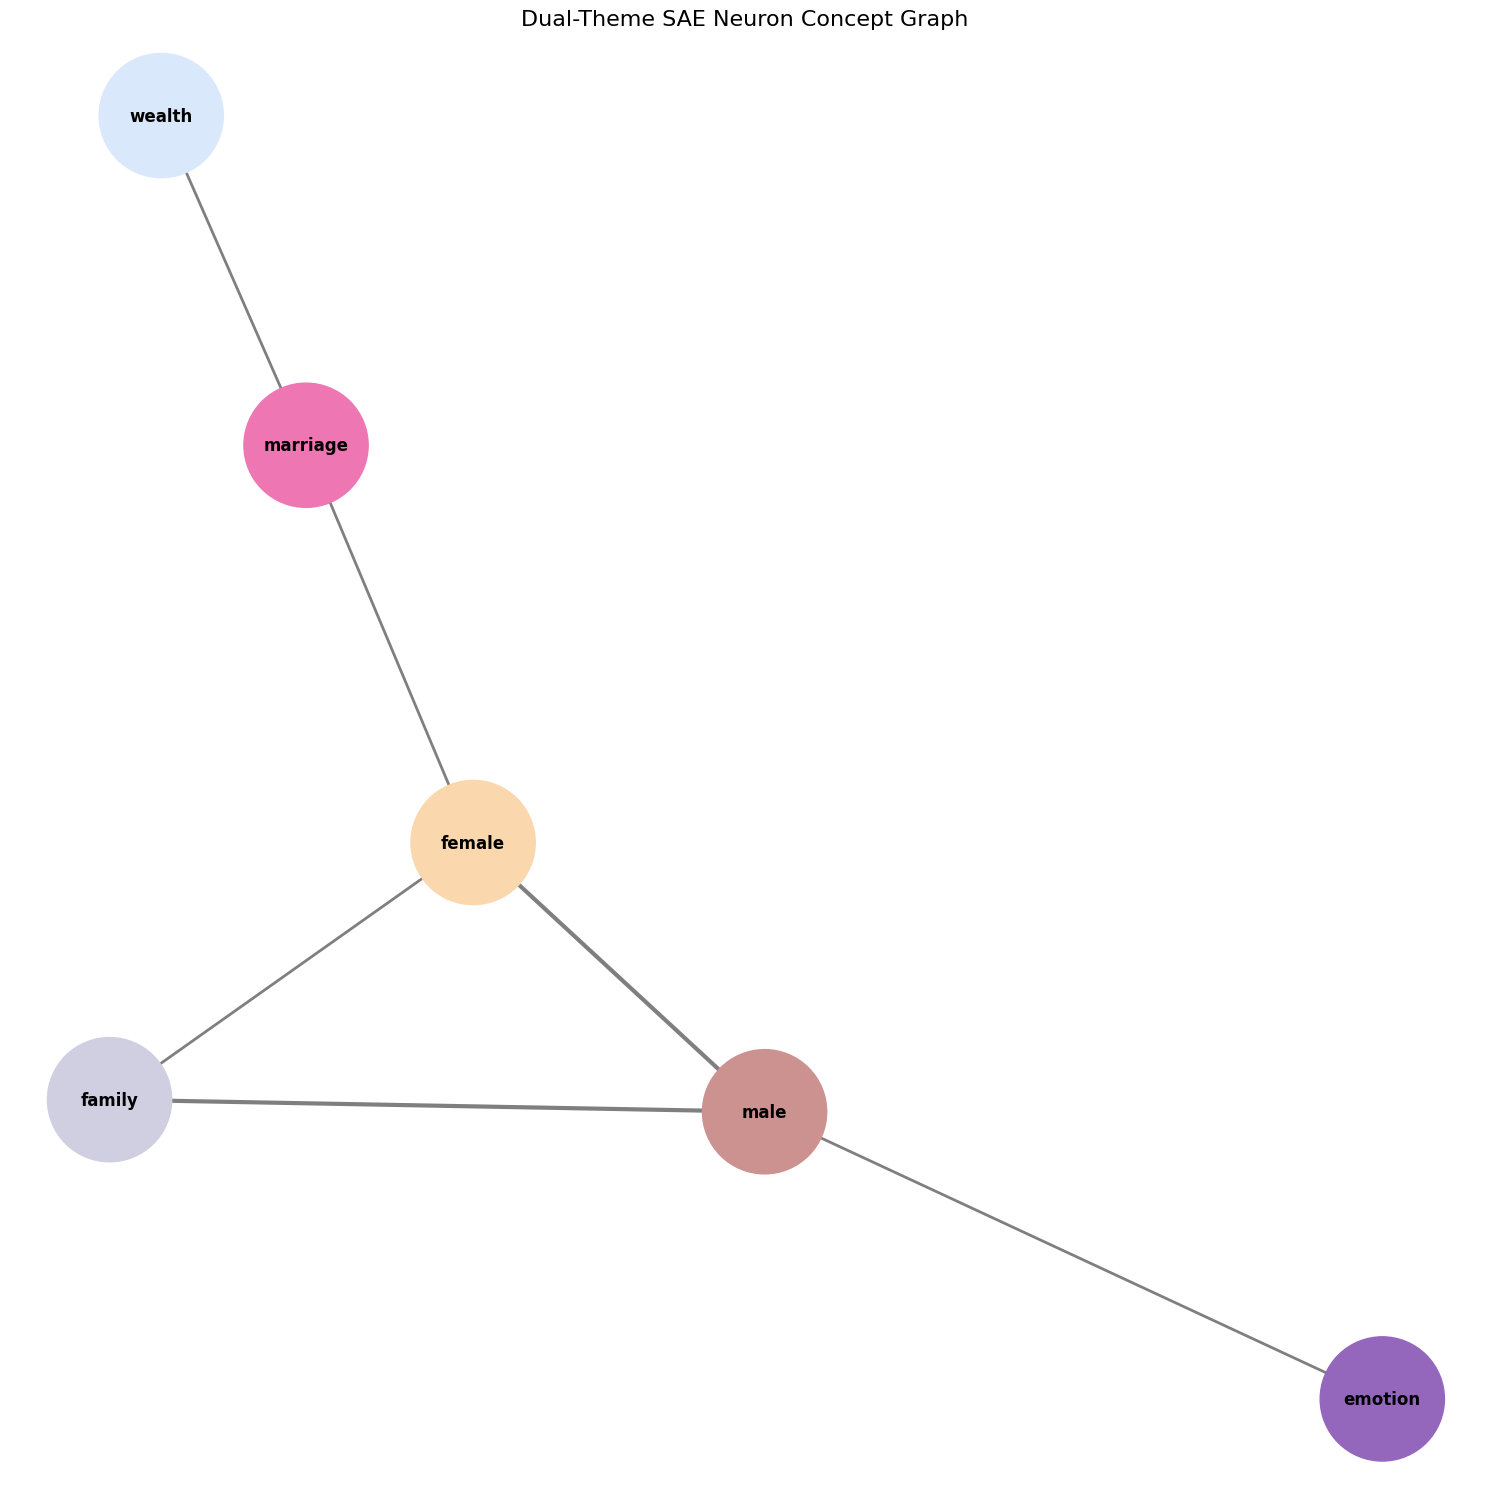

In [32]:
with open("neuron_theme_mapping_l4.json", "r") as f:
    data = json.load(f)

plot_dual_theme_graph(data)

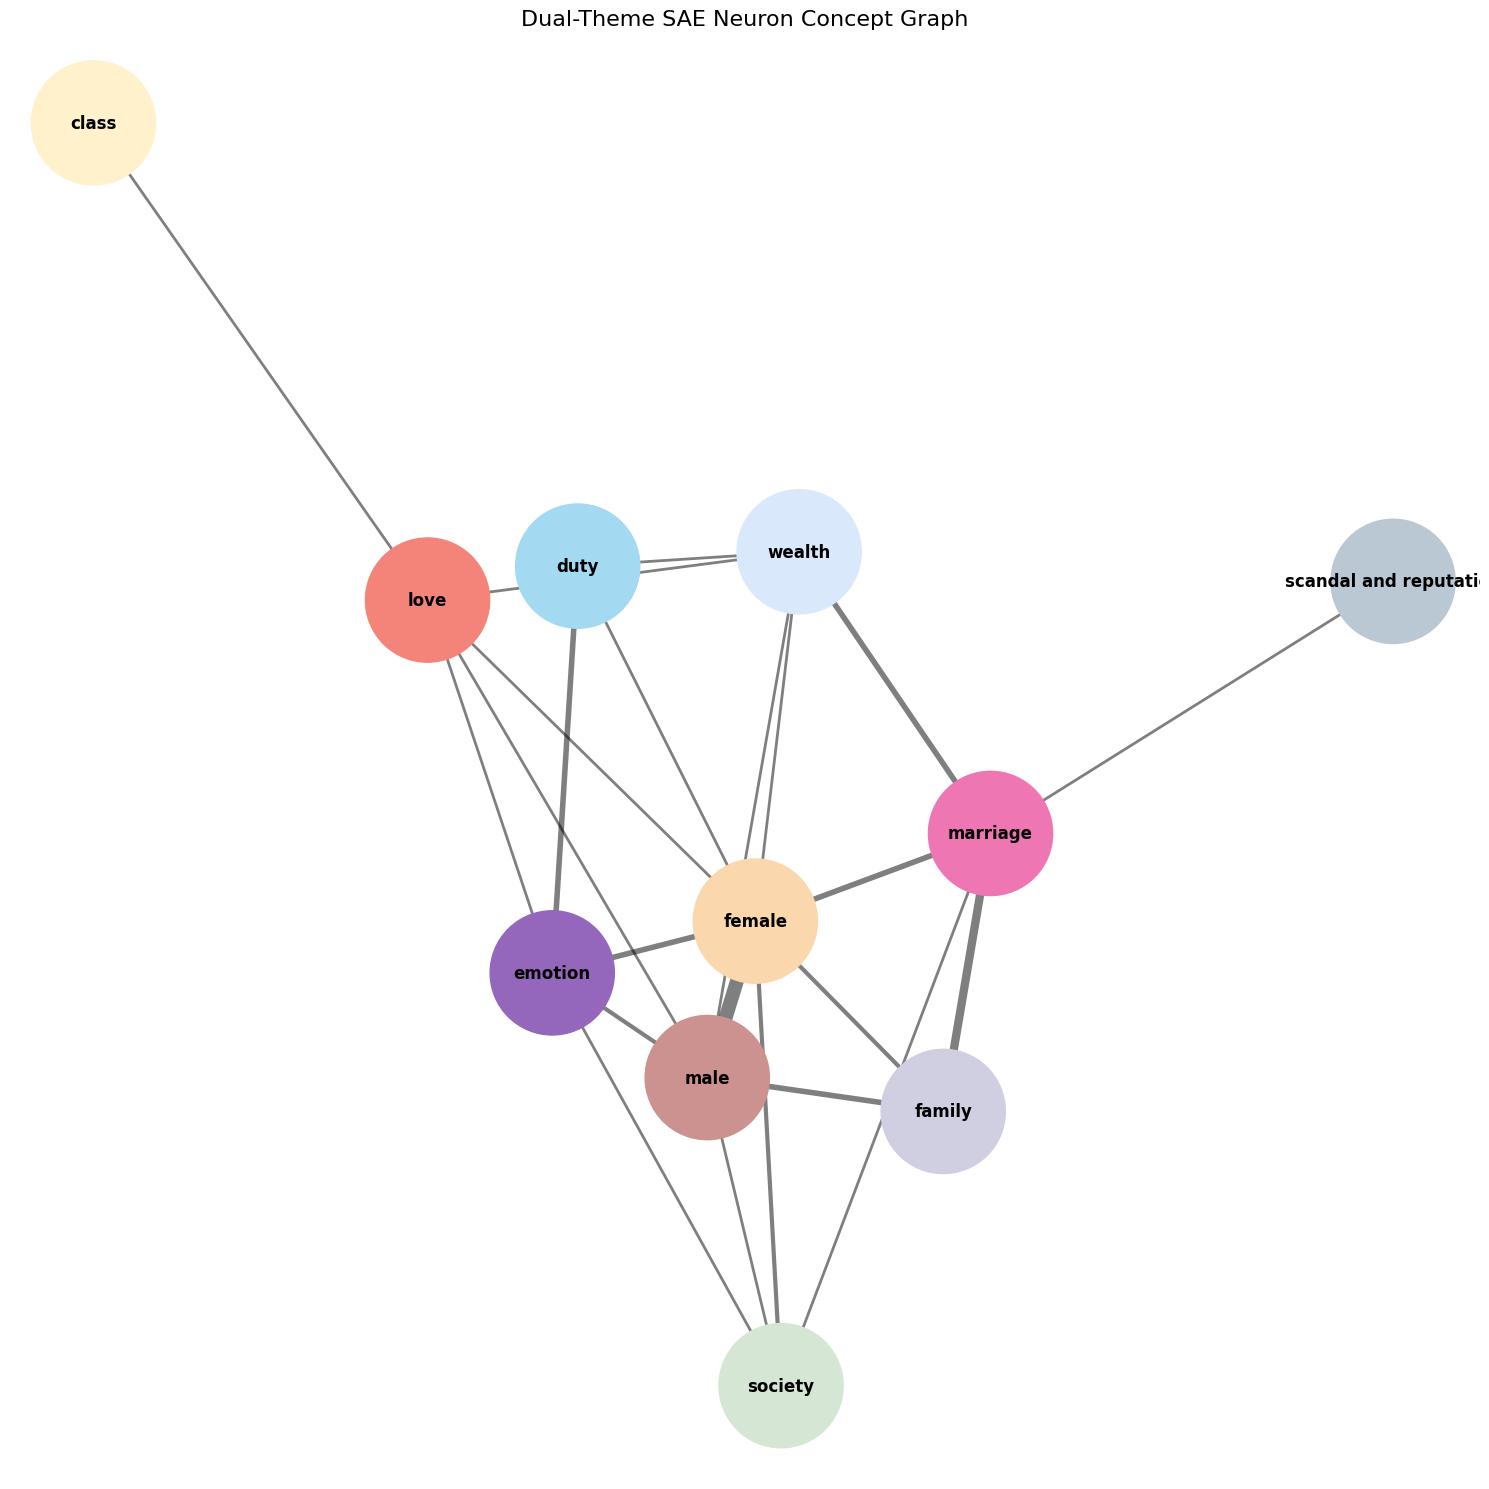

In [33]:
with open("neuron_theme_mapping_l8.json", "r") as f:
    data = json.load(f)

plot_dual_theme_graph(data)